In [1]:
from collections import defaultdict, OrderedDict
import math

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp, entropy

import sim_lib.util as util
import sim_lib.attr_lib.util as alu
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
# Setup
filepath = 'data/opt_mix_comparisons.csv'

md_cols = ['theta', 'p_optim', 'agg_func']
simulations_df = pd.read_csv(filepath, index_col=0)
metric_cols = [ col for col in simulations_df.columns if col not in md_cols ]

for metric in metric_cols:
    simulations_df[metric] = simulations_df[metric].apply(lambda x : [ float(v) for v in x[1:-1].split(', ') ])
simulations_df['sum_util'] = simulations_df.apply(lambda r: np.add(r['attr_util'], r['struct_util']), axis=1)
simulations_df['sum_util_delta'] = simulations_df.apply(lambda r: np.add(r['attr_delta'], r['struct_delta']), axis=1)
metric_cols = [ col for col in simulations_df.columns if col not in md_cols ]

In [3]:
def plot_grid_values(sim_df):
    agg_types = np.sort(pd.unique(sim_df['agg_func']))
    theta_values = np.sort(pd.unique(sim_df['theta']))
    popt_values = np.sort(pd.unique(sim_df['p_optim']))
    
    for theta in theta_values:
        
        # Split into different grids
        fig = plt.figure(figsize=(20, 20))
        plt_idx = 1
        for metric in metric_cols:
            metric_subplots = []
            max_yval = -1
            min_yval = np.infty
            for agt in agg_types:
                metric_cnt = len(sim_df.columns) - len(md_cols)
                params_cnt = len(agg_types)

                sim_metric_vals = sim_df.loc[
                        sim_df['theta'] == theta].loc[
                        sim_df['agg_func'] == agt]

                ax = fig.add_subplot(metric_cnt, params_cnt, plt_idx)
                plt_idx += 1
                ax.set_title(f'{agt} theta={theta}; {metric}')

                metric_vals = sim_metric_vals[['p_optim', metric]]
                alpha_vals = np.linspace(0, 1, num=len(popt_values) + 1)[1:]
                for popt, alpha in zip(popt_values, alpha_vals):
                    y_vals = metric_vals.loc[metric_vals['p_optim'] == popt][metric].iloc[0]
                    x_vals = list(range(1, len(y_vals) + 1))
                    ax.plot(x_vals, y_vals,
                            color='orange', alpha=alpha, label=f'p_optim {popt}')

                    max_yval = max(y_vals) if max(y_vals) > max_yval else max_yval
                    min_yval = min(y_vals) if min(y_vals) < min_yval else min_yval
                    metric_subplots.append(ax)
                        
            for ma in metric_subplots:
                ma.set_ylim([min_yval - 0.05, max_yval + 0.05])                        
                
        fig.tight_layout()

        plt.xlabel('Iteration')
        plt.legend(loc='upper right')
        plt.show()

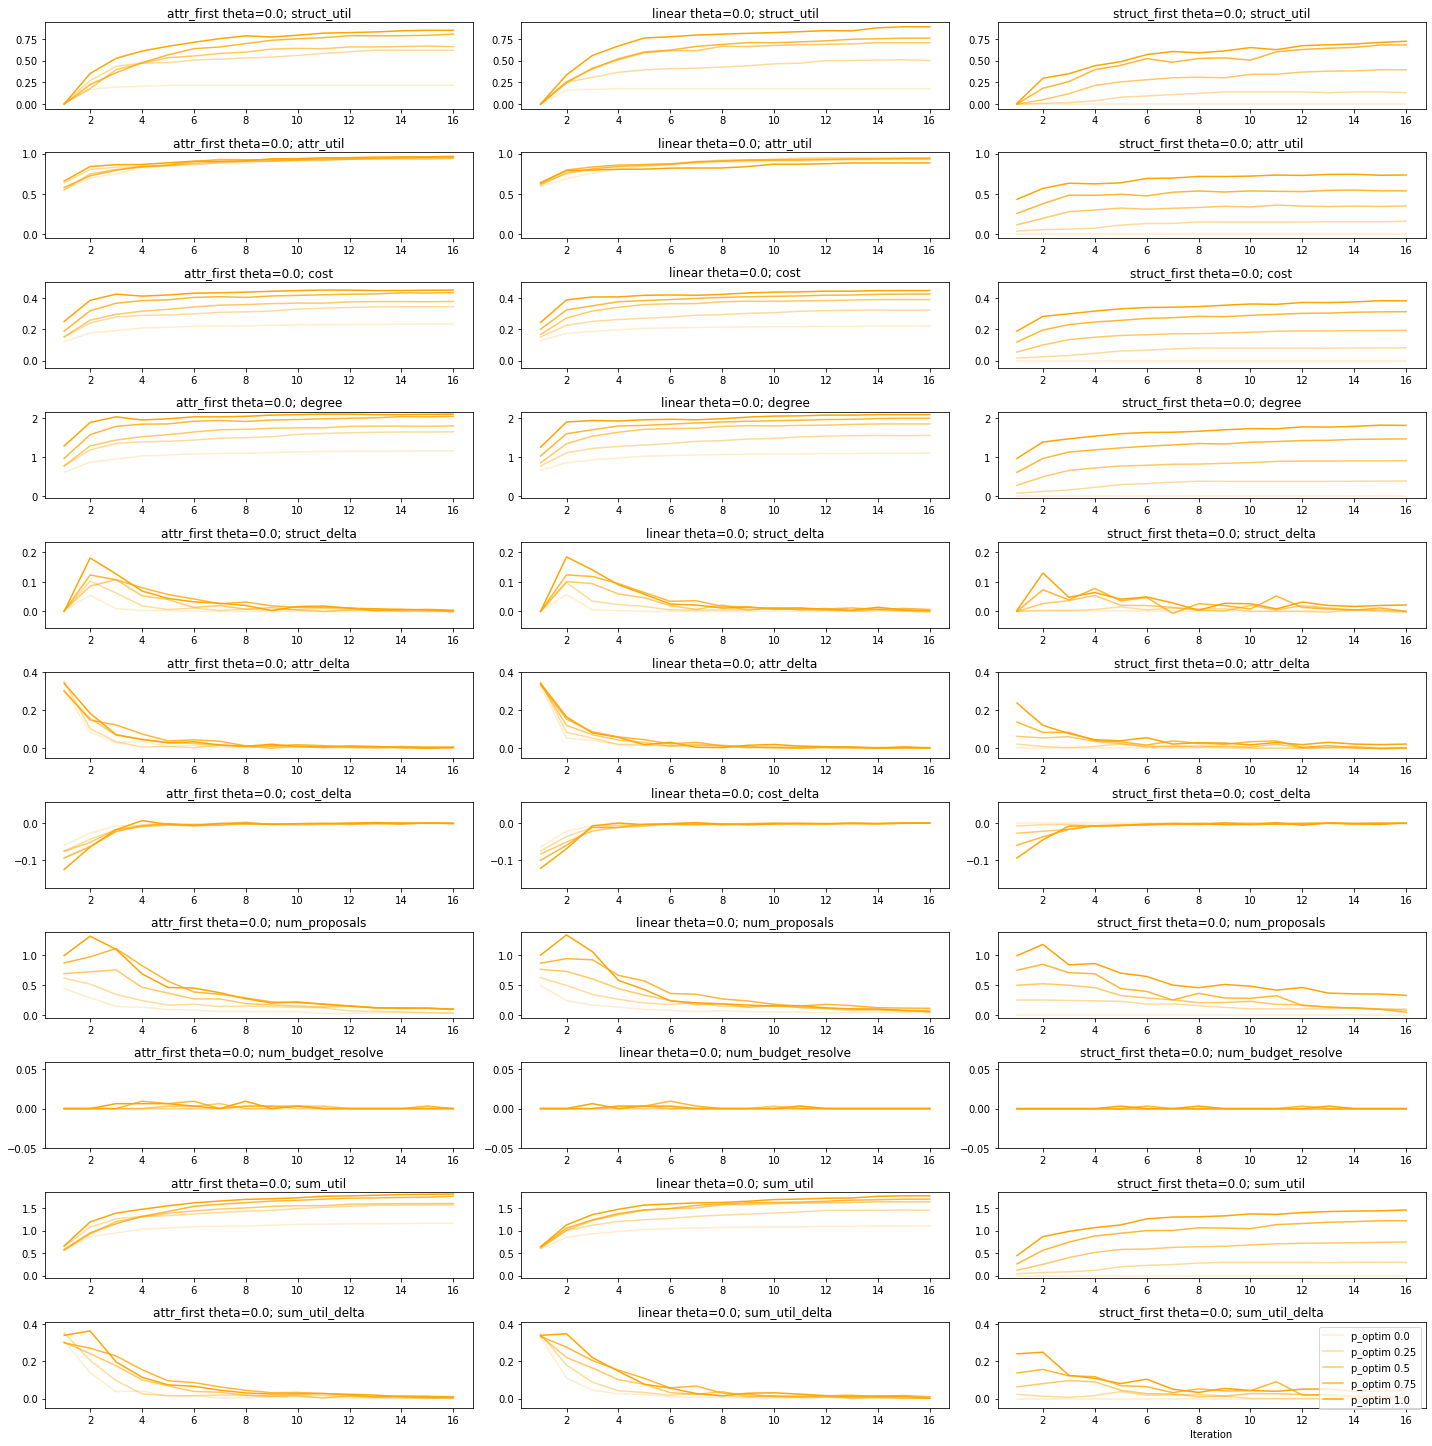

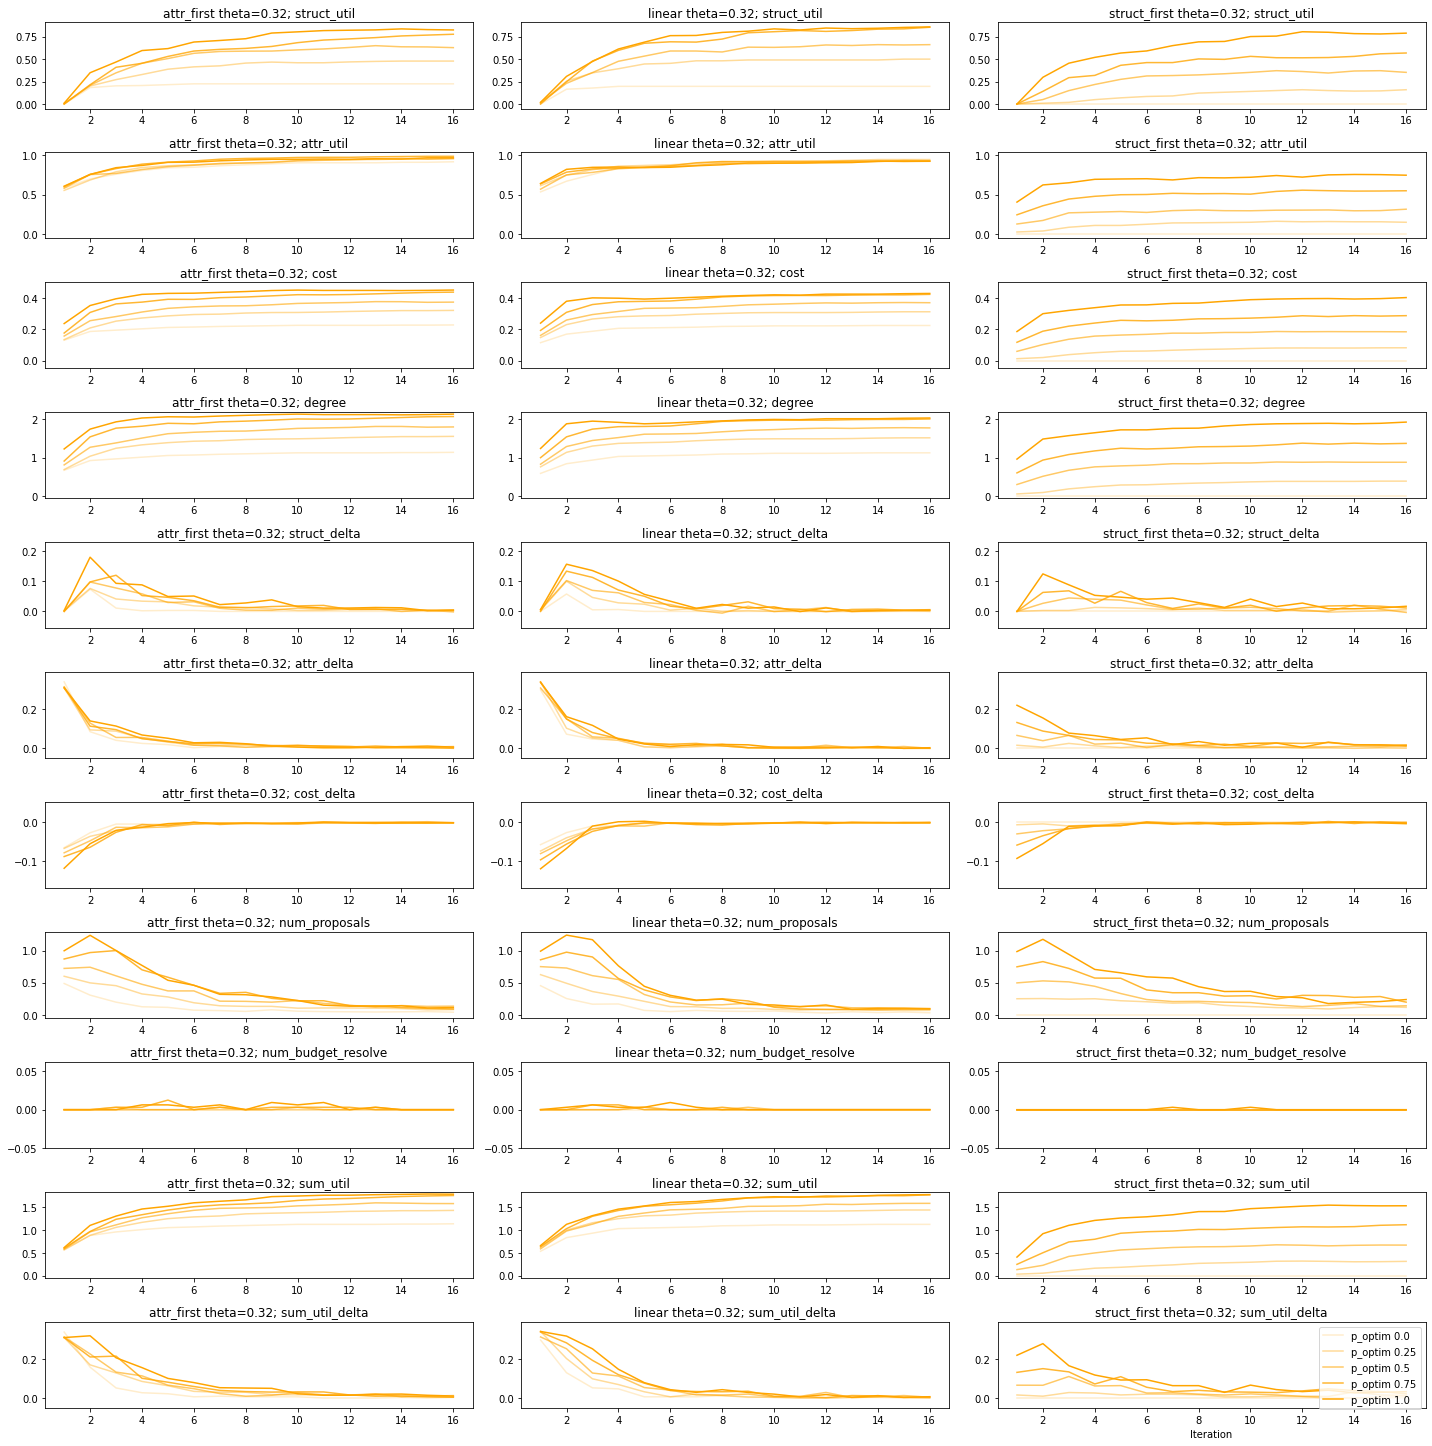

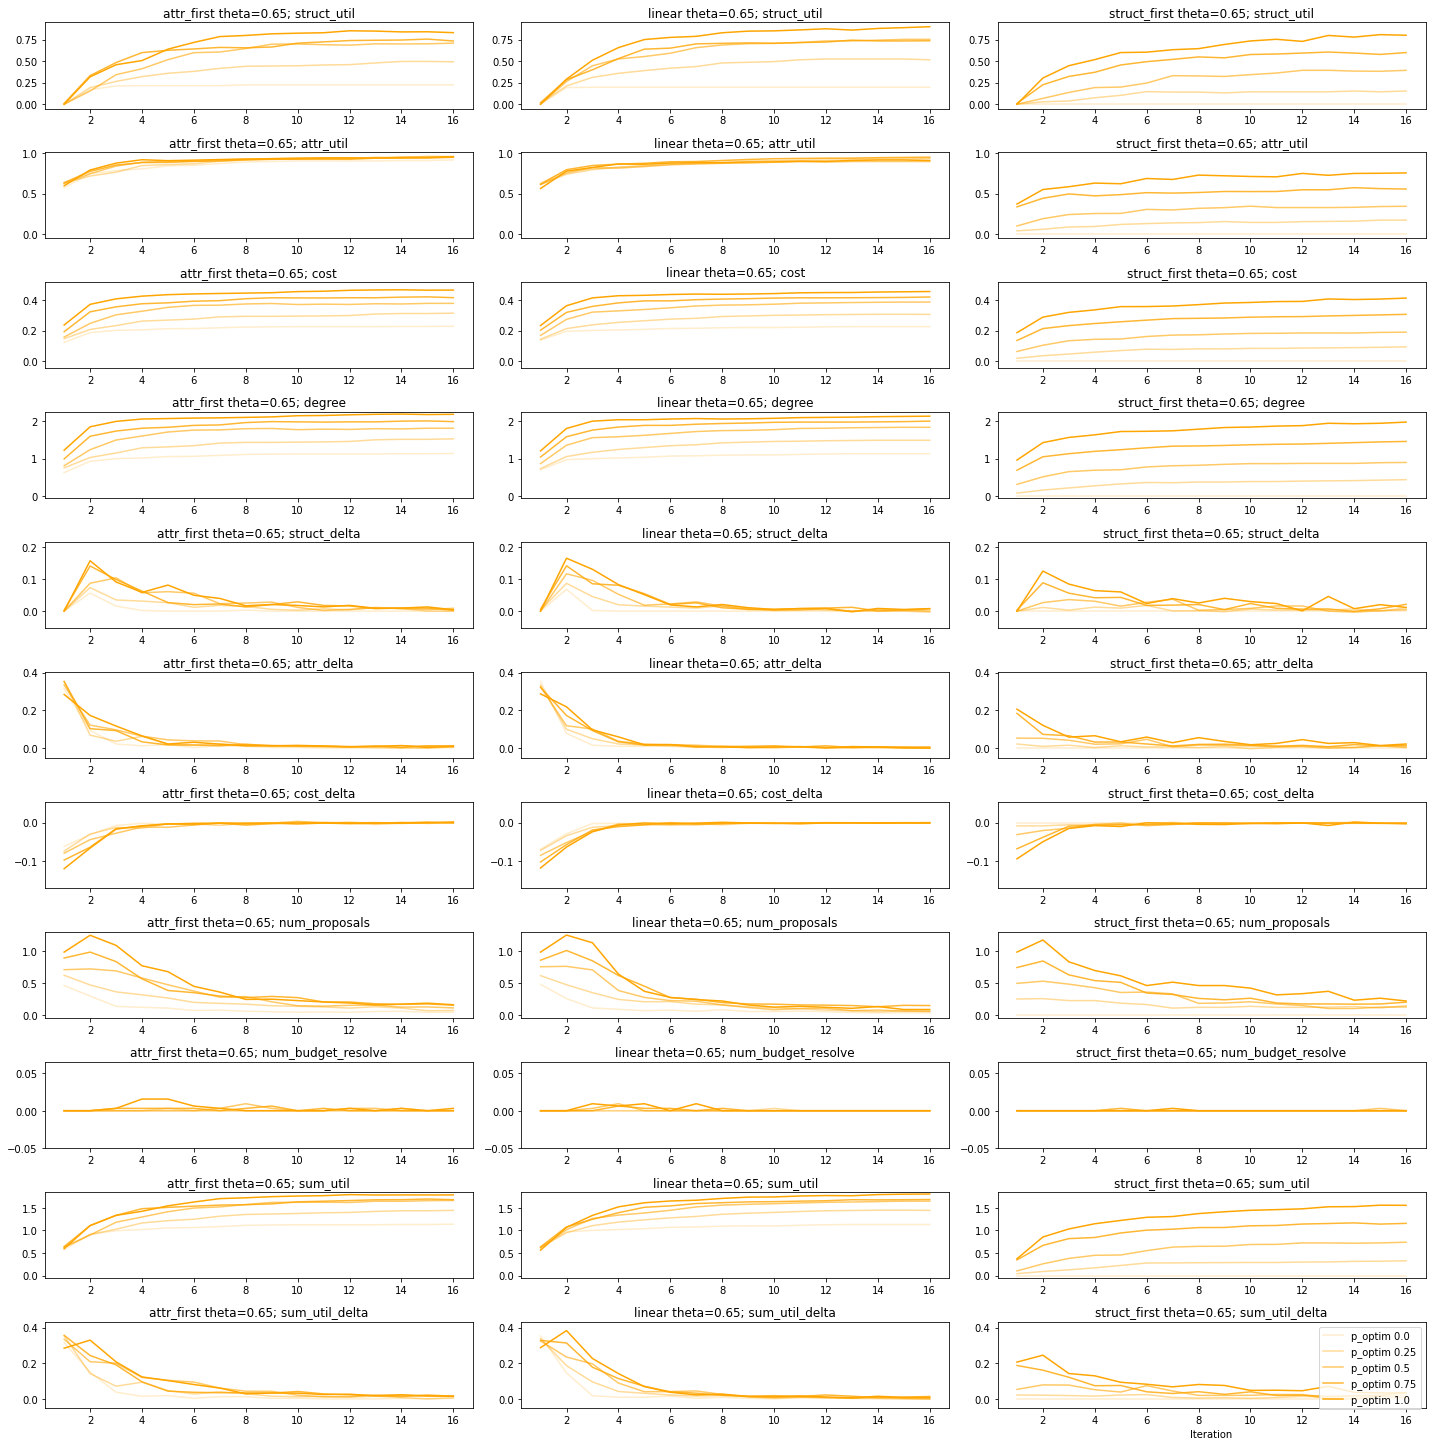

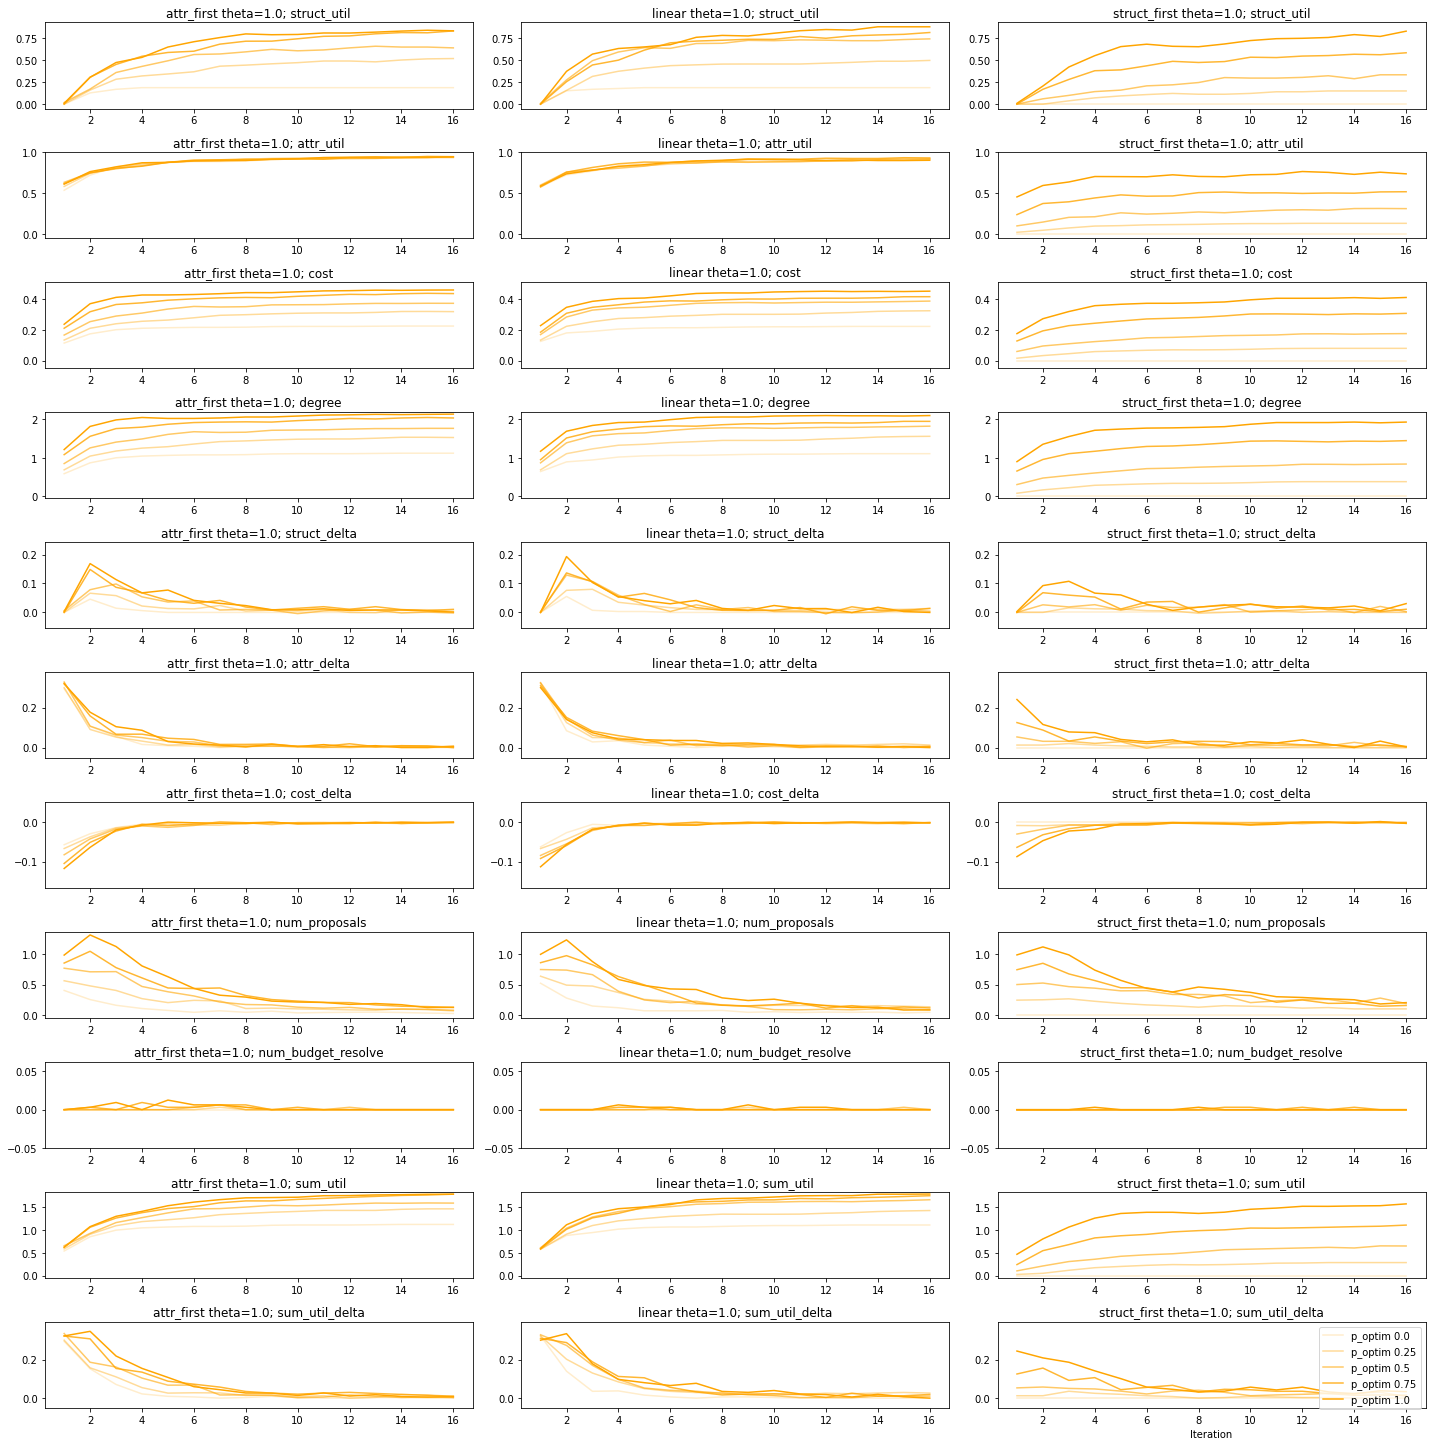

In [4]:
plot_grid_values(simulations_df)